# Mini-project n°2 - Conditional VAEs

## I) Contexte du projet et présentation des CVAE

### I.1) Présentation du projet

Au cours de ce projet, nous avons travaillé sur le jeu de données Fashion-MNIST, qui contient des images de vêtements en vente sur Zalando. Les images de vêtements sont séparés dans 10 catégories au sein du jeu de données, selon le type de l'article (T-shirt/top, pantalon, pull-over, robe, manteau, sandales, chemises, baskets, sacs et bottines). Notre objectif est de cosntruire et d'entrainer un réseau de neurone, qui nous permette de générer des images d'un certain type d'article voulu.

### I.2) Présentation des CVAE

Contrairement à ce que nous avons vu en cours et en TP, nous voulons cette fois générer des images d'une certaine catégorie choisie (par exemple une image de pantalon). Cela ne peut pas être réalisé avec un VAE classique, qui va générer une image aléatoirement dans n'importe quelle catégorie. C'est pourquoi nous allons utiliser un VAE Conditionnel (CVAE).  
Un CVAE est une variante du VAE, où l'on renseigne une variable conditionnelle (dans notre cas le type du vêtement) avec les images. Elles vont ainsi être prises en compte au cours de l'entrainement, puis de la génération d'image, ce qui permettra de sélectionner le type d'image à créer.


Plus formellement, ...

## Library Imports

In [150]:
# Libraries
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cpu


## Hyperparameters

In [193]:
BATCH_SIZE = 128
LATENT_DIM = 10
LEARNING_RATE = 1e-3
EPOCH = 30
KL_WEIGHT = 1 

##  Dataset
The following coad loads the MNIST dataset and builds the necessary dataloaders for training.

In [194]:
# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='../../data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='../../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


## 1. Define the VAE class
- **The Encoder:** The encoder will consist of the following layers:
    - Convolution layer with 32 filters, a kernel size of 4, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Convolution layer with 64 filters, a kernel size of 4, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Convolution layer with 128 filters, a kernel size of 3, stride 2 and padding 1.
    - Batchnorm layer keeping the same number of features
    - ReLU layer

- **The Latent Space:** The encoder outputs are converted into the mean vector $\mu$ and logarithm of the variance vector $\log\sigma^2$, via two paraller fully connected layers. We will need to define:
    - A FC layer to map the output of the encoder $E(x)$ to the mean vector $\mu(x)$.
    - A FC layer to map the output of the encoder $E(x)$ to the log-variance vector $\log\sigma^2(x)$.
    - A FC layer to map the sampled hidden stacte $z(x)\sim\mathcal{N}(\mu(x),Diag(\sigma(x)))$ to the decoder input.

- **The Decoder.** The decoder will consist of the following layers:
    - Deconvolution layer with 64 filters, a kernel size of 3, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Deconvolution layer with 32 filters, a kernel size of 4, stride 2 and padding 1.
    - BatchNorm layer keeping the same number of features
    - ReLu activation
    - Deconvolution layer with 1 filter, a kernel size of 4, stride 2 and padding 1.
    - Sigmoid layer

### Justificatioon 
Just took the one from the VAE code

In [195]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(11, 32, kernel_size=4, stride=2, padding=1),  # 11 channels: 1 for image + 10 for one-hot labels
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )
    
    def encode(self, x, y):
        # Concaténer x (image) et y (vecteur one-hot des classes)
        y = y.view(-1, 10, 1, 1)  # Convertir y en (batch_size, num_classes, 1, 1)
        y = y.expand(-1, -1, 28, 28)  # Agrandir y à (batch_size, num_classes, 28, 28)
        x = torch.cat([x, y], dim=1)  # Concaténation sur le canal (dim=1)

        # Passer par l'encodeur convolutionnel
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Aplatir avant la couche fully connected
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, y):
        # Concaténer z (vecteur latent) avec y (one-hot)
        z = z.view(z.size(0), -1)  # Garder z aplati
        z = self.fc_decode(z)  # Transformation par la fully connected

        z = z.view(-1, 128, 4, 4)  # Recréer les dimensions pour passer au décodeur

        # Appliquer le décodeur convolutionnel
        x = self.decoder(z)
        return x

    def forward(self, x, y):
        # Encode
        mu, logvar = self.encode(x, y)
        # Sample latent vector z
        z = self.sample(mu, logvar)
        # Decode
        return self.decode(z, y), mu, logvar
    
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim) 
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim) 
        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4) 
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )
    
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(-1, 128 * 4 * 4) # Flatten the output of the convolutional layers
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        return self.decode(z), mu, logvar


## Model storage
To ensure a great flexibily, all of the code below use a easily incremental dictionnary to add or remove models that you define juste above

In [196]:
# Default initialisation of a model 
def config_model(model, latente_dim = 10, lr = 1e-3): 
    mod = model(latent_dim=latente_dim)
    mod.to(device)
    optimizer_mod = optim.Adam(mod.parameters(), lr=lr)
    return (mod, optimizer_mod)

In [197]:
# A small function that reinit weights for every models in the dict

def reinit(models_dict):
    for model_name, (model, optimizer) in models_dict.items():
        for layer in model.children():  # runs through the sub-layers of the model.
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()  # Reset settings if possible
    return None

In [198]:
# Dictionnary 
models_dict = {
    'VAE': config_model(ConvVAE, LATENT_DIM, LEARNING_RATE),
    'CVAE': config_model(CVAE, LATENT_DIM, LEARNING_RATE)
}

## 2. Define the loss function

In [199]:
# Loss function that also return BCE and KLD separately as well
def loss_function(recon_x, x, mu, logvar, kl_weight=1.0):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + kl_weight * KLD, BCE, KLD

## 3. Train the VAE

In [200]:
# Training and plotting function
def train(dict_model, train_loader, device, kl_weight=1.0, epochs=30):
    # If it hasn-t been done before, reset the network weights before each training.
    reinit(dict_model)

    # Dictionary to store evolution losses for each model
    evol_losses = {model_name: [] for model_name in dict_model.keys()}
    evol_bce = {model_name: [] for model_name in dict_model.keys()}
    evol_kl = {model_name: [] for model_name in dict_model.keys()}

    # Training phase over epochs
    for epoch in range(1, epochs + 1):

        # Variables to accumulate losses during the period
        running_losses = {model_name: 0.0 for model_name in dict_model.keys()}
        bce_losses = {model_name: 0.0 for model_name in dict_model.keys()}
        kld_losses = {model_name: 0.0 for model_name in dict_model.keys()}
        
        for (data, labels) in train_loader:
            # Move data and labels to the GPU (if available)
            data = data.to(device) 
            labels = torch.eye(10)[labels].to(device)  # One-hot encoding des labels

            # Loop for each model in the dictionary
            for model_name, (model, optimizer) in dict_model.items():
                model.train()
                optimizer.zero_grad()  

                # Models are differentiated according to whether they take labels into account
                if model_name == "VAE":
                    recon_batch, mu, logvar = model(data)  # VAE only takes 'data'
                else:
                    recon_batch, mu, logvar = model(data, labels)  # Others take the labels too
                
                loss, bce, kld = loss_function(recon_batch, data, mu, logvar, kl_weight)                

                loss.backward()
                optimizer.step()

                running_losses[model_name] += loss.item()
                bce_losses[model_name] += bce.item()
                kld_losses[model_name] += kld.item()

        # Calculate average losses for each model at the end of the period
        for model_name in dict_model.keys():
            epoch_loss = running_losses[model_name] / len(train_loader.dataset)
            epoch_bce = bce_losses[model_name] / len(train_loader.dataset)
            epoch_kld = kld_losses[model_name] / len(train_loader.dataset)

            evol_losses[model_name].append(epoch_loss)
            evol_bce[model_name].append(epoch_bce)
            evol_kl[model_name].append(epoch_kld)

            # Display during training
            print(f'Epoch {epoch}: Model {model_name} - Loss: {epoch_loss:.4f}, BCE: {epoch_bce:.4f}, KLD: {epoch_kld:.4f}')
    
    # Storage of losses that can be reused later (display)
    loss_dict = {
        'evol_losses': evol_losses,
        'evol_bce': evol_bce,
        'evol_kl': evol_kl
    }
    return loss_dict





loss_dict = train(dict_model=models_dict, train_loader=train_loader, device=device, kl_weight=KL_WEIGHT, epochs=EPOCH)

"""
# Run training and plotting for different KL weights
for kl_weight in kl_weights:
    print(f'\nTraining VAE with KL Weight = {kl_weight}')
    train_and_plot(kl_weight=1.0, dict_model=models_dict, train_loader=train_loader, device=device, epochs=num_epochs)


"""


Epoch 1: Model VAE - Loss: 150.4219, BCE: 135.0102, KLD: 15.4117
Epoch 1: Model CVAE - Loss: 168.1223, BCE: 152.8006, KLD: 15.3217
Epoch 2: Model VAE - Loss: 113.1602, BCE: 95.1378, KLD: 18.0224
Epoch 2: Model CVAE - Loss: 114.7800, BCE: 97.0244, KLD: 17.7556
Epoch 3: Model VAE - Loss: 109.3017, BCE: 90.7834, KLD: 18.5183
Epoch 3: Model CVAE - Loss: 110.5491, BCE: 92.2244, KLD: 18.3247
Epoch 4: Model VAE - Loss: 107.2658, BCE: 88.4888, KLD: 18.7770
Epoch 4: Model CVAE - Loss: 108.3076, BCE: 89.7025, KLD: 18.6051
Epoch 5: Model VAE - Loss: 105.9339, BCE: 87.0547, KLD: 18.8792
Epoch 5: Model CVAE - Loss: 106.8342, BCE: 88.0406, KLD: 18.7936
Epoch 6: Model VAE - Loss: 105.0594, BCE: 86.0701, KLD: 18.9894
Epoch 6: Model CVAE - Loss: 105.7512, BCE: 86.8720, KLD: 18.8792
Epoch 7: Model VAE - Loss: 104.3736, BCE: 85.2950, KLD: 19.0786
Epoch 7: Model CVAE - Loss: 104.9187, BCE: 85.9196, KLD: 18.9990
Epoch 8: Model VAE - Loss: 103.7024, BCE: 84.5767, KLD: 19.1257
Epoch 8: Model CVAE - Loss: 104

"\n# Run training and plotting for different KL weights\nfor kl_weight in kl_weights:\n    print(f'\nTraining VAE with KL Weight = {kl_weight}')\n    train_and_plot(kl_weight=1.0, dict_model=models_dict, train_loader=train_loader, device=device, epochs=num_epochs)\n\n\n"

## Plot loss evolution
Here we plot the loss fucntions for each models to seek for differences


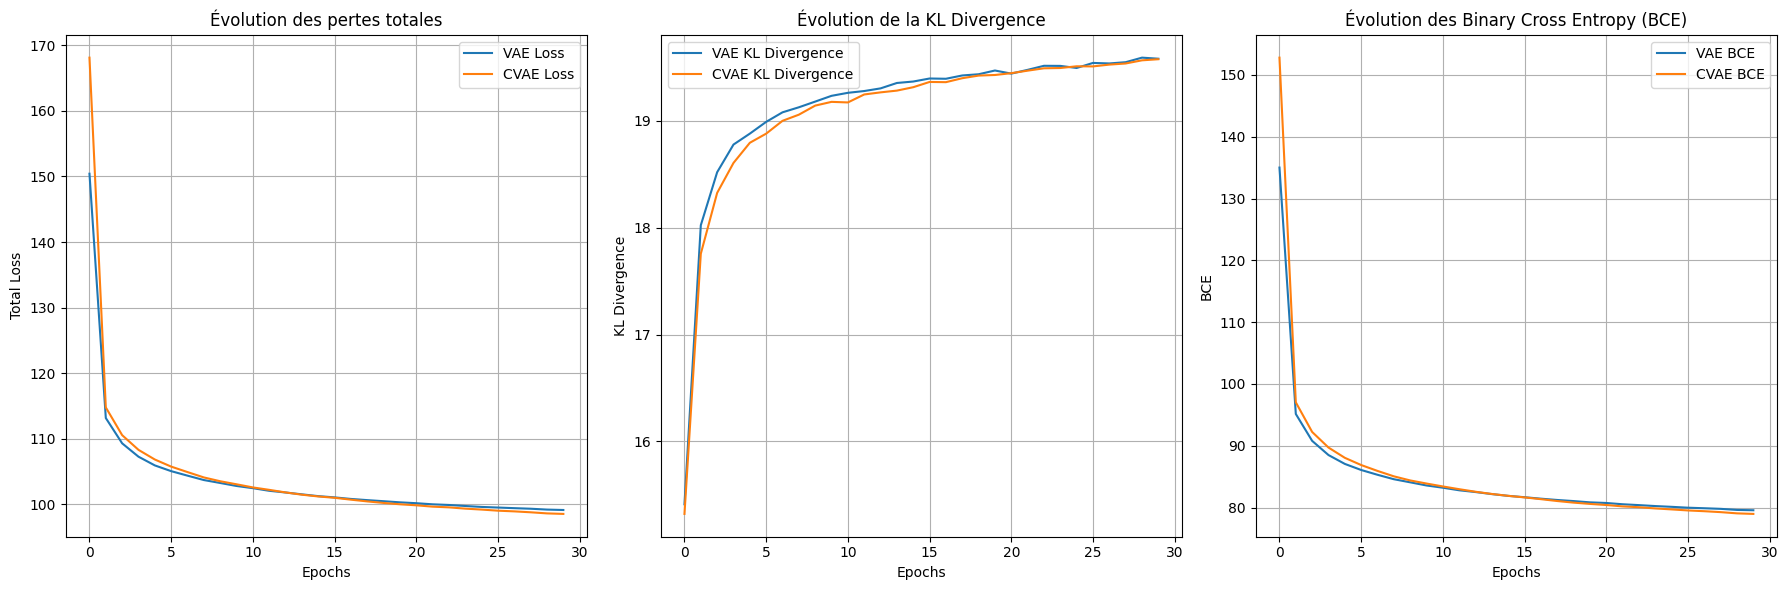

In [201]:
def plot_losses(evol_losses, evol_bce, evol_kl):
    plt.figure(figsize=(18, 6))

    # Graph 1 : Total loss
    plt.subplot(1, 3, 1)
    for model_name, losses in evol_losses.items():
        plt.plot(losses, label=f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Total Loss')
    plt.title('Évolution des pertes totales')
    plt.legend()
    plt.grid(True)

    # Graph 2 : KL Divergence
    plt.subplot(1, 3, 2)
    for model_name, kl_losses in evol_kl.items():
        plt.plot(kl_losses, label=f'{model_name} KL Divergence')
    plt.xlabel('Epochs')
    plt.ylabel('KL Divergence')
    plt.title('Évolution de la KL Divergence')
    plt.legend()
    plt.grid(True)

    # Graph 3 : Binary Cross Entropy (BCE)
    plt.subplot(1, 3, 3)
    for model_name, bce_losses in evol_bce.items():
        plt.plot(bce_losses, label=f'{model_name} BCE')
    plt.xlabel('Epochs')
    plt.ylabel('BCE')
    plt.title('Évolution des Binary Cross Entropy (BCE)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_losses(loss_dict['evol_losses'], loss_dict['evol_bce'], loss_dict['evol_kl'])

In [ ]:
def image_comparison(original_images, dict_recons, n_images=6):
    """Plots the original images and their reconstructions for comparison

    Args:
        original_images (torch.Tensor): The original images
        dict_recons (dict): Dictionary with reconstruction labels as keys and images as values
        n_images (int): Number of images to display
    """

    # Créer une figure avec un nombre de lignes correspondant aux reconstructions + 1 pour les images originales
    fig, ax = plt.subplots(len(dict_recons) + 1, n_images, figsize=(20, 7))

    # Affichage des images originales
    for i in range(n_images):
        ax[0, i].imshow(original_images[i], cmap='gray')
        ax[0, i].axis('off')
        ax[0, 0].set_title('Original')

    # Affichage des reconstructions
    for row, (key, value) in enumerate(dict_recons.items(), start=1):
        for i in range(n_images):
            ax[row, i].imshow(value[i], cmap='gray')
            ax[row, i].axis('off')
            ax[row, 0].set_title(key)

    plt.tight_layout()
    plt.show()

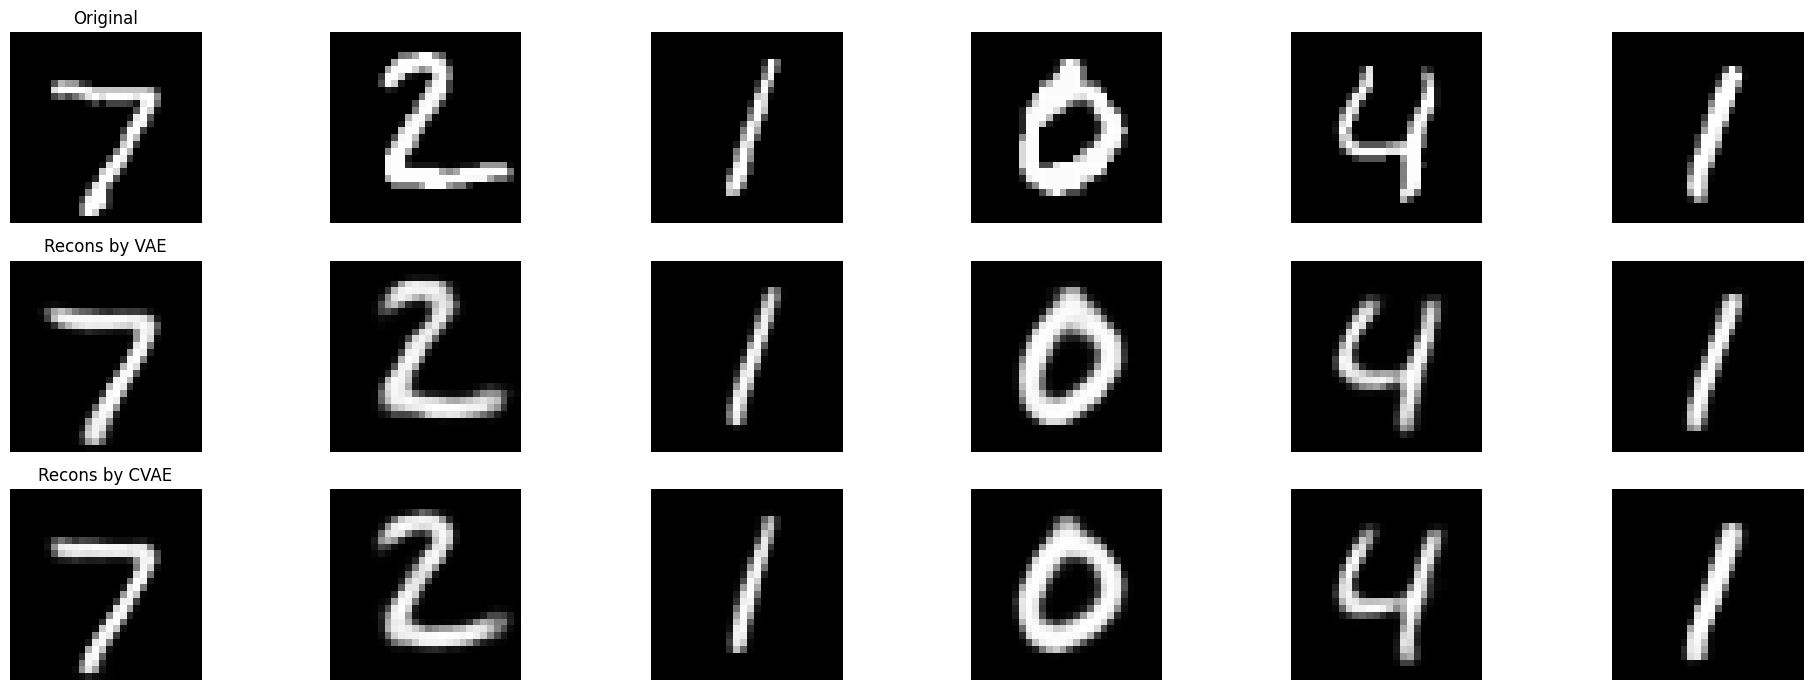

In [202]:
# Function for obtaining and comparing image reconstructions

def compare_model_reconstructions(models_dict, test_loader, device):

    random_images, random_labels = next(iter(test_loader))

    random_labels_one_hot = torch.eye(10)[random_labels].to(device) #One hot encoding

    random_images = random_images.to(device)
    
    # Dictionary for storing model reconstructions
    dict_recons = {}


    for model_name, (model, _) in models_dict.items():
        model.eval()

        with torch.no_grad():
            if "VAE" == model_name: 
                recons, _, _ = model(random_images)
            else:  # Pour les modèles comme VAE, pas besoin des labels
                recons, _, _ = model(random_images, random_labels_one_hot)
            
            # Prepare reconstructions for display
            recons = recons.detach().cpu().numpy().squeeze()  # [batch_size, 1, 28, 28] -> [batch_size, 28, 28]
            dict_recons[f"Recons by {model_name}"] = recons

    # Préparer les images originales pour l'affichage
    random_images = random_images.cpu().numpy().squeeze()  # [batch_size, 1, 28, 28] -> [batch_size, 28, 28]

    # Display original images and their reconstructions
    image_comparison(random_images, dict_recons)


# Comparison of model reconstructions
compare_model_reconstructions(models_dict, test_loader, device)



## 5. Image generation
The puropose of this section is to generate new images that look like MNIST digits for every trained models. In order to do so, we follow the steps below:
- Sample $z$ from a $\mathcal{N}(0, I)$ distribution ($I$ being the identity matrix of size $p$).
- Decode $z$ using the decoder of the VAE to generate a new image.
- Add the contionning if necessary


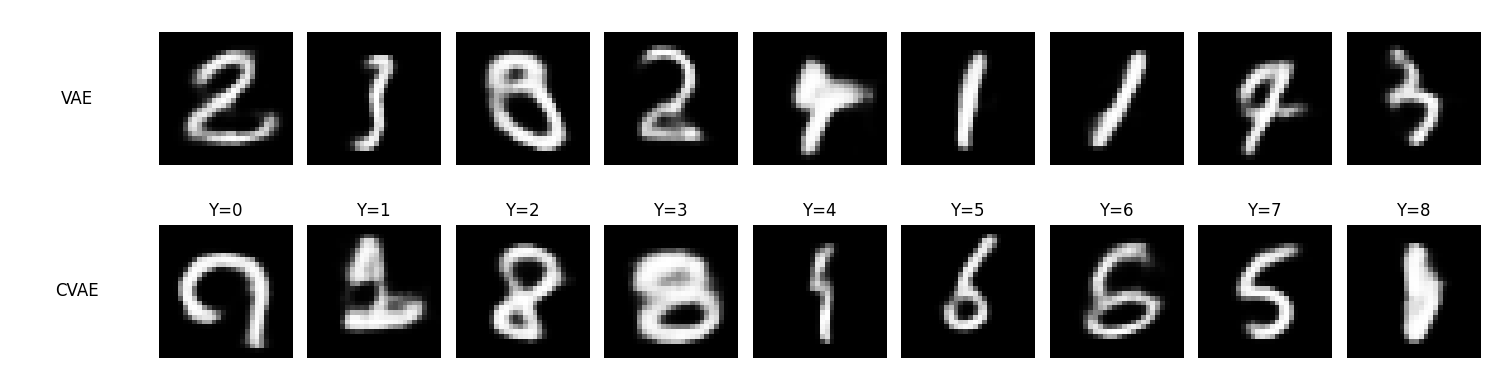

In [205]:
def generate_samples(models_dict, num_samples=9):
    # Set all models to evaluation mode
    for model_name, (model, _) in models_dict.items():  # Extract only the model
        model.eval()

    with torch.no_grad():
        # Generate `y` labels (a list from 0 to num_samples-1 to ensure they match classes)
        y = torch.eye(10)[:num_samples].to(device) 
        z = torch.randn(num_samples, LATENT_DIM).to(device)  # Random latent vectors
        
        num_models = len(models_dict)
        
        # Create figure with dynamic subplots: (num_models rows, num_samples + 1 columns)
        fig, ax = plt.subplots(num_models, num_samples + 1, figsize=(15, 2 * num_models))
        
        # Loop over the models to generate samples
        for i, (model_name, (model, _)) in enumerate(models_dict.items()):
            # Use decode method depending on whether it's a VAE or CVAE
            if "VAE" == model_name:  
                samples = model.decode(z)  # VAE doesn't use labels
            else:
                samples = model.decode(z, y)  # CVAE uses labels

            samples = samples.cpu().view(num_samples, 1, 28, 28)  # Reshape the samples
            
            # Display model name in the first column (extra column added for the name)
            ax[i, 0].text(0.5, 0.5, f'{model_name}', horizontalalignment='center', 
                          verticalalignment='center', fontsize=12, transform=ax[i, 0].transAxes)
            ax[i, 0].axis('off')  # Turn off axis for the model name column
            
            # Display samples for this model
            for j in range(1, num_samples + 1):  # Start at 1 to account for the extra column
                ax[i, j].imshow(samples[j-1].squeeze(0), cmap='gray')  # Adjust index for samples
                ax[i, j].axis('off')
                if "CVAE" in model_name: 
                    ax[i, j].set_title(f'Y={j-1}')  # Display the labels for which use labels

        plt.tight_layout()
        plt.show()

# Call function
generate_samples(models_dict=models_dict)


## Latent Spaces
Here we are comparing latetns space to seek for differences 

In order to be able to visualize the latent space of the VAE, we retrain the model and will choose a latent dimension equal to 2.

In [ ]:
models_dict = {
    'VAE': config_model(ConvVAE, latente_dim=2,lr = LEARNING_RATE),
    'CVAE': config_model(CVAE, latente_dim=2, lr = LEARNING_RATE)
}

_ = train(dict_model=models_dict, train_loader=train_dataset, device=device, kl_weight=KL_WEIGHT, epochs= EPOCH)



# Function to plot latent space
def plot_latent_space(models_dict, test_dataset, device, kl_weight=1.0) :
    # Fig initialisation
    plt.figure(figsize=(16, 6))
    
    for i, (model_name, (model, _)) in enumerate(models_dict.items(), 1):

        model.eval()
        with torch.no_grad():

            test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
            data, labels = next(iter(test_loader))
            data = data.to(device)
            labels = labels.to(device)

            # Adjust label size to match data batch_size
            if labels.size(0) != data.size(0):
                raise RuntimeError(f"Les tailles des données ({data.size(0)}) et des labels ({labels.size(0)}) ne correspondent pas.")
                

            # Manage labels to match data (One-hot encoding already supported)
            if labels.dim() == 1:  # If labels are in integer form (not encoded)
                labels = torch.eye(10)[labels].to(device)  # One-hot encodes if necessary

            if model_name == "VAE":
                mu, _ = model.encode(data)
            else:
                mu, _ = model.encode(data, labels)

            z = mu  
            z = z.cpu().numpy()
            labels = labels.cpu().numpy()

            # Sub-graph for each model
            plt.subplot(1, 2, i)
            scatter = plt.scatter(z[:, 0], z[:, 1], c=labels.argmax(axis=1), cmap='tab10', alpha=0.7)  # Utilise les labels comme catégories
            plt.colorbar(scatter, ticks=range(10))
            plt.clim(-0.5, 9.5)
            plt.title(f'{model_name} Latent Space with KL Weight = {kl_weight}')
            plt.xlabel('Z1')
            plt.ylabel('Z2')

    plt.tight_layout()
    plt.show()


plot_latent_space(models_dict=models_dict, test_dataset= test_dataset, device =device,  kl_weight=KL_WEIGHT)